### Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob

%matplotlib inline

### Helper Functions: Thresholding

In [2]:
def grayscale(img):
    
    """ Applies the Grayscale transform
    This will return an image with only one color channel.
    
    NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    """ Returns a binary based on directional 
    gradient thresholding"""
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_img = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel_img = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_img)
    
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 4) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1  
    
    # 5) Return this mask as your binary_output image
    return sbinary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    """ Returns a binary based on gradient
    magnitude thresholding"""
    
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobely = np.absolute(sobely)
    
    # 2) Calculate the magnitude
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 4) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 5) Return this mask as your binary_output image
    return sxybinary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    """ Returns a binary based on gradient
    direction thresholding"""
    
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 2) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    
    """ Returns a binary based on S channel
    thresholding"""
    
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:, :, 2])
    binary_output[(hls[:, :, 2] > thresh[0]) & (hls[:, :, 2] <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result

    return binary_output

def rgb_select(img, thresh=(0, 255)):
    
    """ Returns a binary based on S channel
    thresholding"""
    
    # 1) Apply a threshold to the S channel
    binary_output = np.zeros_like(img[:, :, 0])
    binary_output[(img[:, :, 0] > thresh[0]) & (img[:, :, 0] <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result

    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Helper Functions: Lane and Curvature Detection

In [3]:
def sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin   # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    
    try:
        det = True
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        det = False
        left_fit = np.array([1, 1, 0], np.float32)
        right_fit = np.array([1, 1, 0], np.float32)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, det

def lane_search(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    try:
        det = True
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        det = False
        left_fit = np.array([1, 1, 0], np.float32)
        right_fit = np.array([1, 1, 0], np.float32)
    
    img_shape = binary_warped.shape
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    ## End visualization steps ##
    
    return result, left_fit, right_fit, left_fitx, right_fitx, ploty, det

def curvature(img_shape, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Scaling factors in X and Y
    mx = 3 / 1000 # meters per pixel
    my = 30 / 720 # meters per pixel
    
    # Calculate radius at bottom most pixel
    y_eval = img_shape[1]
    y_cr = my * y_eval
    
    # Scale parabola
    scale = np.array([mx / my **2, mx / my, mx], np.float32)
    left_fit_cr = np.multiply(scale, left_fit)
    right_fit_cr = np.multiply(scale, right_fit)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_cr + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_cr + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    
    # Calculate vehicle to lane center offset
    x_left = left_fit_cr[0] * y_cr ** 2 + left_fit_cr[1] * y_cr + left_fit_cr[2]
    x_right = right_fit_cr[0] * y_cr ** 2 + right_fit_cr[1] * y_cr + right_fit_cr[2]
    
    left_base_pos = x_left - img_shape[0] * mx / 2
    right_base_pos = x_right - img_shape[0] * mx / 2
    
    offset = ((x_left + x_right) - img_shape[0] * mx) / 2
    
    return left_curverad, right_curverad, offset, left_base_pos, right_base_pos

### Camera Calibration

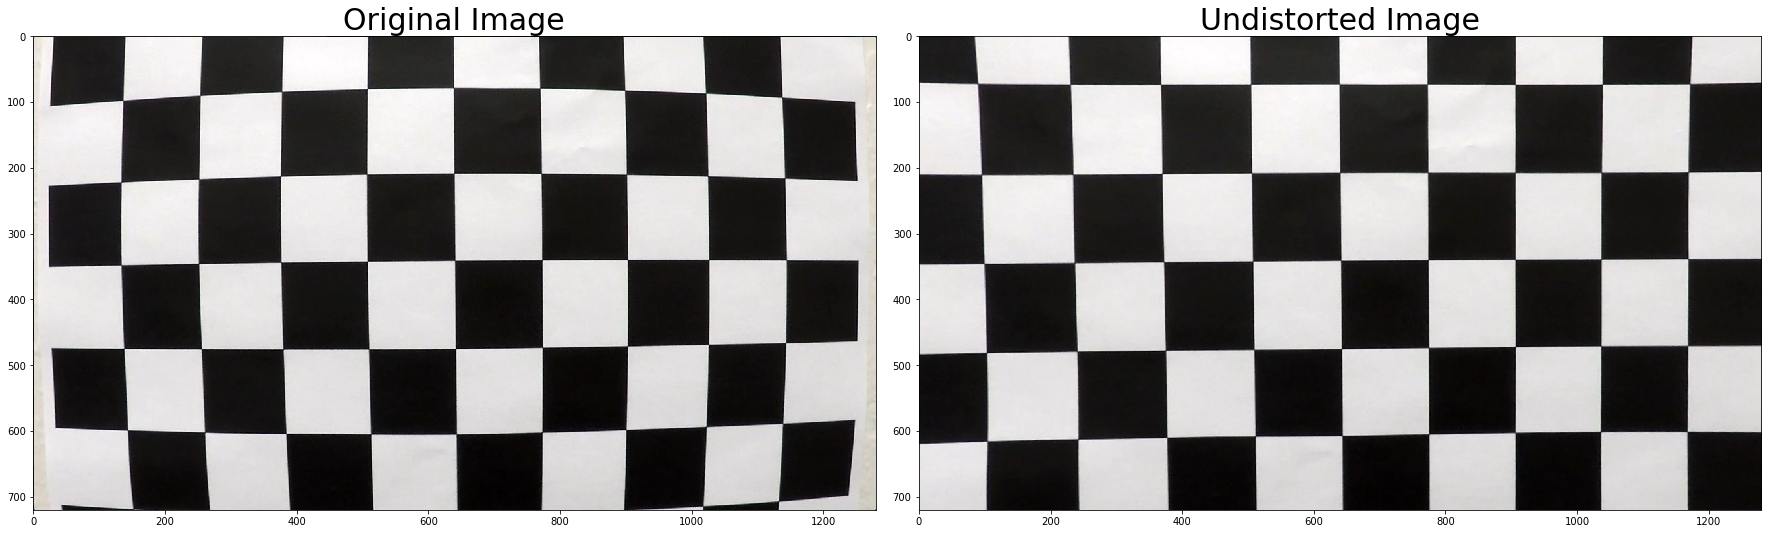

In [4]:
# Read in calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Read in calibration images
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

nx = 9
ny = 6

# Populate object points [0, 0, 0] , ... , [nx, ny, 0]
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

for fname in images:

    # Read in the image file
    image = mpimg.imread(fname)

    # Convert to grayscale
    gray = grayscale(image)

    #plt.imshow(gray, cmap='gray')

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# Calculate camera distortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Choose an image for validating camera correction
image = mpimg.imread(images[0])

# Undistort using camera distortion coefficients
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Plot Original and Undistorted Image for comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Distortion Correction

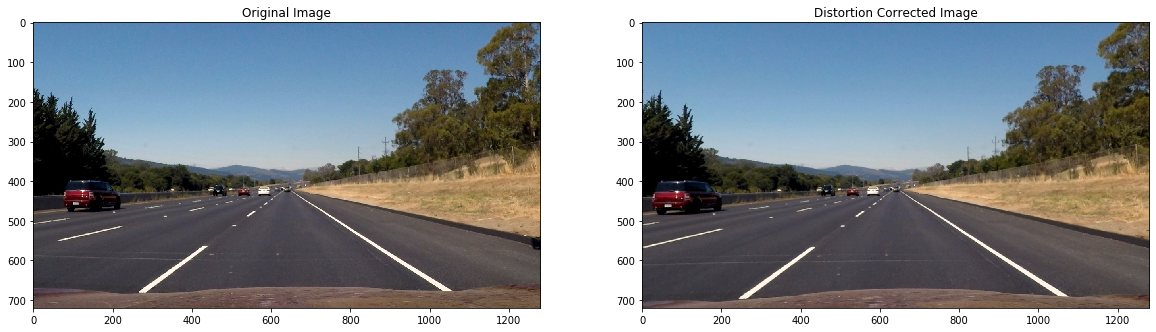

In [5]:
# Read in test image
image = mpimg.imread('test_images/straight_lines2.jpg')
img_size = (image.shape[1], image.shape[0])
#plt.imshow(image)

# Undistort
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Plotting Distortion Corrected Images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(image)
ax2.set_title('Distortion Corrected Image')
ax2.imshow(undist)

### Color and Gradient Thresholding

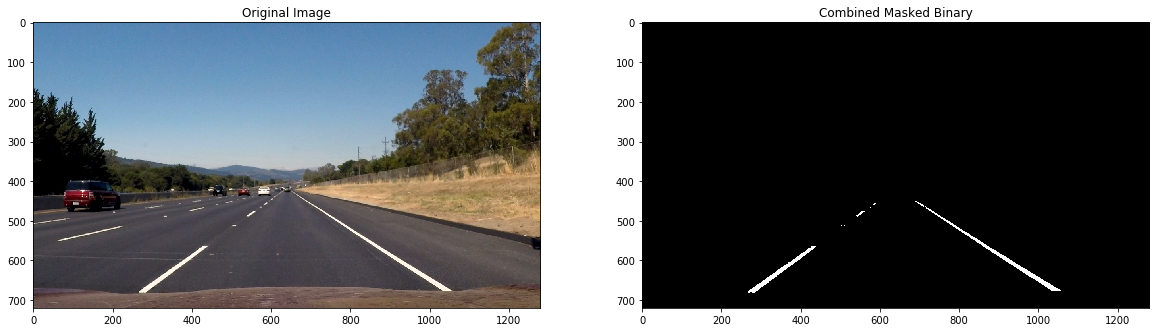

In [6]:
# Convert to grayscale
gray = grayscale(undist)
#plt.imshow(gray, cmap='gray')

# X Thresholding
gradx = sobel_thresh(gray, orient='x', sobel_kernel=15, thresh=(20, 200))
#plt.imshow(gradx, cmap='gray')

# Y Thresholding
grady = sobel_thresh(gray, orient='y', sobel_kernel=15, thresh=(20, 200))
#plt.imshow(grady, cmap='gray')

# Magnitude Thresholding
mag_bin = mag_thresh(gray, sobel_kernel=15, thresh=(30, 200))
#plt.imshow(mag_bin, cmap='gray')

# Direction Thresholding
dir_bin = dir_thresh(gray, sobel_kernel=15, thresh=(0.7, 1.3))
#plt.imshow(dir_bin, cmap='gray')

# 'S' channel Thresholding
s_bin = hls_select(image, thresh=(150, 255))
#plt.imshow(s_bin, cmap='gray')

# 'R' channel Thresholding
r_bin = rgb_select(image, thresh=(150, 255))
#plt.imshow(r_bin, cmap='gray')

# Combine thresholds
combination = np.zeros_like(dir_bin)
combination[(((gradx == 1) & (grady == 1) & (r_bin == 1)) | ((mag_bin == 1) & (dir_bin == 1) & (r_bin == 1)) | ((s_bin == 1) & (r_bin == 1)))] = 255
#plt.imshow(combination, cmap='gray')

# Mask unwanted edges

x1 = np.int(0 * img_size[0])
x2 = np.int(0.4 * img_size[0])
x3 = np.int(0.6 * img_size[0])
x4 = np.int(1 * img_size[0])

horizon = np.int(img_size[1]/1.6)

vertices = np.array([[(x1, img_size[1]), (x2, horizon), (x3, horizon), (x4, img_size[1])]], dtype=np.int32)
masked_combination = region_of_interest(combination, vertices)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(image)

ax2.set_title('Combined Masked Binary')
ax2.imshow(masked_combination, cmap='gray')

### Calculate Perspective Transform

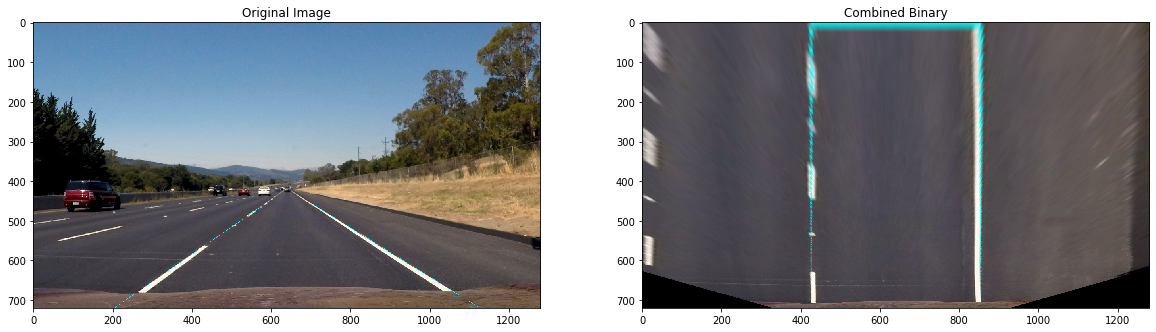

In [7]:
# Tune coefficients to capture perspective
x1 = np.int(0.16 * img_size[0])
x2 = np.int(0.465 * img_size[0])
x3 = np.int(0.54 * img_size[0])
x4 = np.int(0.88 * img_size[0])
x5 = np.int(1 / 3 * img_size[0])
x6 = np.int(2 / 3 * img_size[0])

horizon = img_size[1]/1.6

src = np.float32([[x1, img_size[1]], [x2, horizon], [x3, horizon], [x4, img_size[1]]])
dst = np.float32([[x5, img_size[1]], [x5, 0], [x6, 0], [x6, img_size[1]]])

pts = np.array([[x1, img_size[1]], [x2, horizon], [x3, horizon], [x4, img_size[1]]], np.int32)
pts = pts.reshape((-1, 1, 2))

# Get perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

image = cv2.polylines(image, [pts],True,(0, 255, 255))

# Warp image
image_warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

# Warp combination
binary_warped = cv2.warpPerspective(masked_combination, M, img_size, flags=cv2.INTER_LINEAR)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(image)

ax2.set_title('Combined Binary')
ax2.imshow(image_warped, cmap='gray')

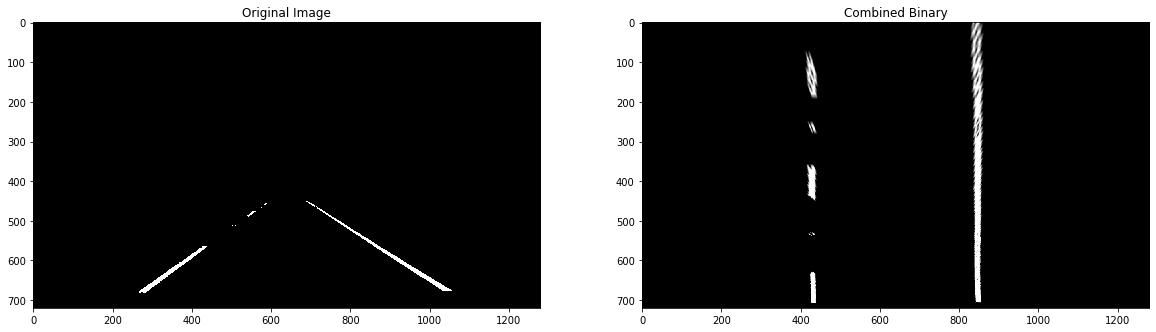

In [8]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(masked_combination, cmap = 'gray')

ax2.set_title('Combined Binary')
ax2.imshow(binary_warped, cmap='gray')

### Lane Detection using Sliding Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


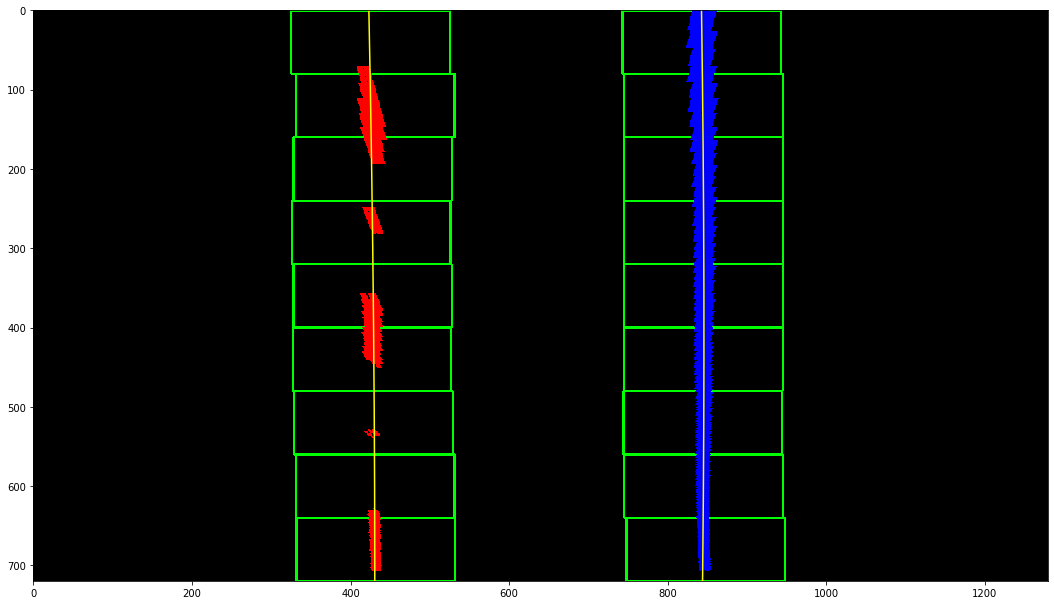

In [9]:
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, det = sliding_window(binary_warped)
plt.imshow(out_img)

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Calculate Curvature

In [10]:
curv_l, curv_r, offset, left_base_pos, right_base_pos = curvature(img_size, left_fit, right_fit)
curv = (curv_l + curv_r) / 2

### Lane Search around detected Polynomial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


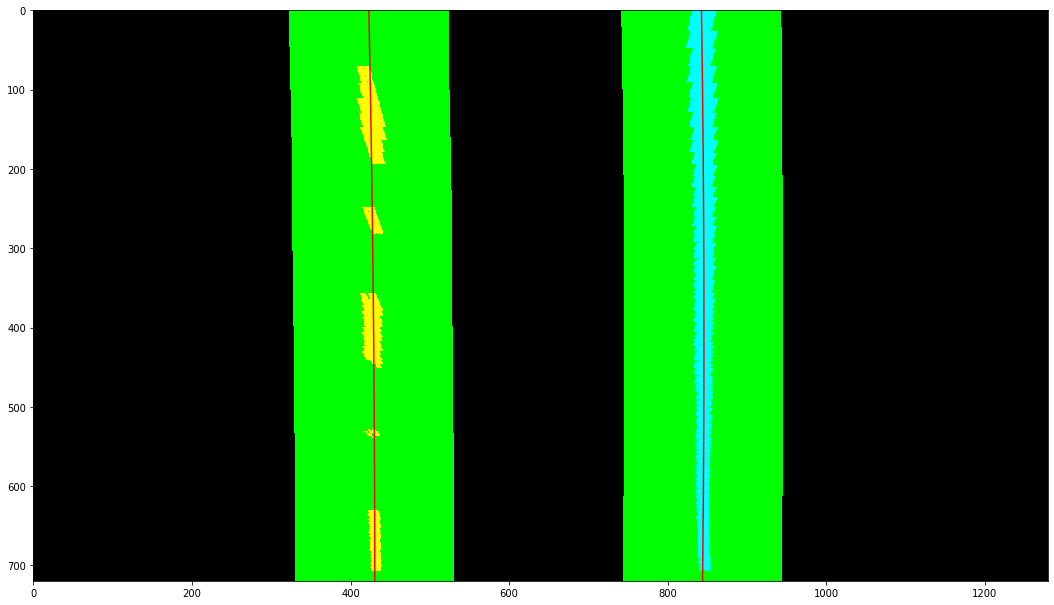

In [11]:
result, left_fit, right_fit, left_fitx, right_fitx, ploty, det = lane_search(binary_warped, left_fit, right_fit)
plt.imshow(result)

# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
    
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Project Detected Lane

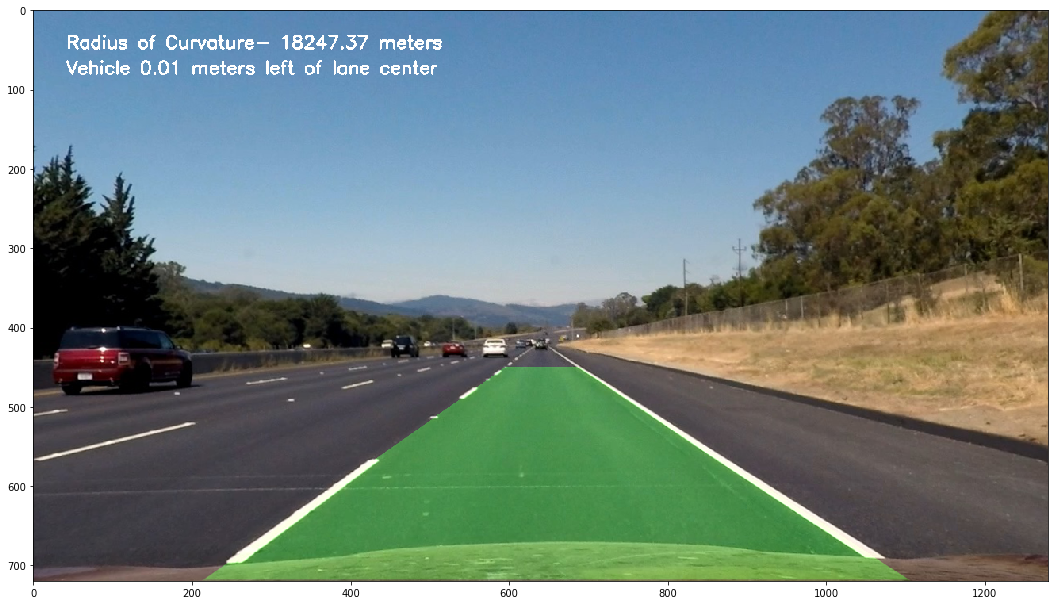

In [12]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

text1 = 'Radius of Curvature- ' + str(round(curv, 2)) + ' meters'

if(offset < 0):
    text2 = 'Vehicle ' + str(np.absolute(round(offset, 2))) + ' meters left of lane center'
else:
    text2 = 'Vehicle ' + str(round(offset, 2)) + ' meters right of lane center'

result = cv2.putText(result, text1, (img_size[0] // 30, img_size[1] // 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 255], 2)
result = cv2.putText(result, text2, (img_size[0] // 30, img_size[1] // 9), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 255], 2)

plt.imshow(result)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Test Images

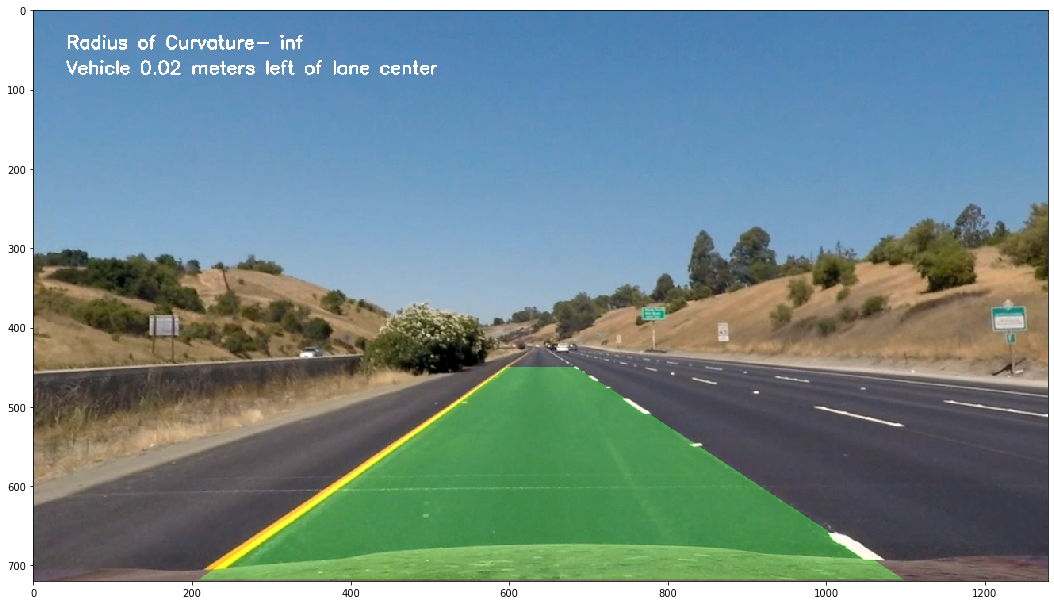

In [13]:
# Read in test image
image = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (image.shape[1], image.shape[0])
# plt.imshow(image)

# Undistort
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Convert to grayscale
gray = grayscale(undist)
# plt.imshow(gray, cmap='gray')

# X Thresholding
gradx = sobel_thresh(gray, orient='x', sobel_kernel=15, thresh=(20, 200))
# plt.imshow(gradx, cmap='gray')

# Y Thresholding
grady = sobel_thresh(gray, orient='y', sobel_kernel=15, thresh=(20, 200))
# plt.imshow(grady, cmap='gray')

# Magnitude Thresholding
mag_bin = mag_thresh(gray, sobel_kernel=15, thresh=(30, 200))
# plt.imshow(mag_bin, cmap='gray')

# Direction Thresholding
dir_bin = dir_thresh(gray, sobel_kernel=15, thresh=(0.7, 1.3))
# plt.imshow(dir_bin, cmap='gray')

# 'S' channel Thresholding
s_bin = hls_select(image, thresh=(150, 255))
# plt.imshow(s_bin, cmap='gray')

# 'R' channel Thresholding
r_bin = rgb_select(image, thresh=(150, 255))
#plt.imshow(r_bin, cmap='gray')

# Combine thresholds
combination = np.zeros_like(dir_bin)
combination[(((gradx == 1) & (grady == 1) & (r_bin == 1)) | ((mag_bin == 1) & (dir_bin == 1) & (r_bin == 1)) | ((s_bin == 1) & (r_bin == 1)))] = 255
# plt.imshow(combination, cmap='gray')

# # Plotting thresholded images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('Original Image')
# ax1.imshow(image)

# ax2.set_title('combination Masked Binary')
# ax2.imshow(combination, cmap='gray')

# Mask unwanted edges

masked_combination = region_of_interest(combination, vertices)

# Warp combination
binary_warped = cv2.warpPerspective(masked_combination, M, img_size, flags=cv2.INTER_LINEAR)

# plt.imshow(binary_warped, cmap='gray')
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, det = sliding_window(binary_warped)
# plt.imshow(out_img)
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

curv_l, curv_r, offset, left_base_pos, right_base_pos = curvature(img_size, left_fit, right_fit)
curv = (curv_l + curv_r) / 2

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

if(curv < 8000):
    text1 = 'Radius of Curvature- ' + str(round(curv, 2)) + ' meters'
else:
    curv = float('inf')
    text1 = 'Radius of Curvature- ' + str(round(curv, 2))

if(offset < 0):
    text2 = 'Vehicle ' + str(np.absolute(round(offset, 2))) + ' meters left of lane center'
else:
    text2 = 'Vehicle ' + str(round(offset, 2)) + ' meters right of lane center'

result = cv2.putText(result, text1, (img_size[0] // 30, img_size[1] // 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 255], 2)
result = cv2.putText(result, text2, (img_size[0] // 30, img_size[1] // 9), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 255], 2)

plt.imshow(result)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Lane Detection Pipeline

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Lane Class

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        # coefficients of the last n fits of the line
        self.nfits = []
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None 
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] 
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        #Iterations
        self.n = 0
        
        #Lost lane counts
        self.lost_counts = 0
    
    def update(self, det, current_fit, curv, line_base_pos, xfitted, ploty):
                
        if (det == False):
            self.detected = False
            self.lost_counts = self.lost_counts + 1
        else:       
            self.diffs = np.subtract(self.current_fit, current_fit)
            self.current_fit = current_fit
            
            self.allx = xfitted # No use of this line
            self.ally = ploty # No use of this line
            
            if (self.n == 0):
                
                self.recent_xfitted = xfitted
                self.nfits = current_fit
                self.best_fit = current_fit
                self.bestx = xfitted
                self.radius_of_curvature = curv 
                self.line_base_pos = line_base_pos
                self.n = self.n + 1
                
            ### Validate detected frame ###
            
            # Validate Fit            
            self.diffs = np.subtract(self.current_fit, self.best_fit)
            if (max(np.absolute(np.divide(self.diffs, self.best_fit))) > 0.005):
                self.detected == False
                self.lost_counts = self.lost_counts + 1
            
            # Validate Curvature
            elif(np.divide(np.absolute(curv - self.radius_of_curvature), self.radius_of_curvature) > 0.1):
                self.detected == False
                self.lost_counts = self.lost_counts + 1
                
            # Validate Offset
            elif(np.divide(np.absolute(line_base_pos - self.line_base_pos), self.line_base_pos) > 0.075):
                self.detected == False
                self.lost_counts = self.lost_counts + 1
                
            else:
                self.lost_counts = 0
                self.detected = True
                
            ### Update lane parameters based on validation results ###
                
            if ((self.n > 0) & (self.n < 20) & self.detected == True):
                
                self.recent_xfitted = np.vstack([self.recent_xfitted, xfitted])
                self.nfits = np.vstack([self.nfits, current_fit])
                self.n = self.n + 1
                
            elif((self.n == 20) & self.detected == True):
                
                self.recent_xfitted = np.delete(self.recent_xfitted, 0, axis=0)
                self.recent_xfitted = np.vstack([self.recent_xfitted, xfitted])
                self.nfits = np.delete(self.nfits, 0, axis=0)
                self.nfits = np.vstack([self.nfits, current_fit])
            
            elif((self.n == 20) & self.detected == False):
                self.recent_xfitted = np.delete(self.recent_xfitted, 0, axis=0)
                self.nfits = np.delete(self.nfits, 0, axis=0)
                self.n = self.n - 1
                                    
            self.best_fit = np.mean(self.nfits, axis=0)
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            self.radius_of_curvature = curv 
            self.line_base_pos = line_base_pos
        

In [16]:
# Lane Instances

In [17]:
left_line = Line()
right_line = Line()

In [18]:
def process_image(image):
    
    img_size = (image.shape[1], image.shape[0])
    
    # Undistort input image
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    # Convert to grayscale
    gray = grayscale(undist)
    # plt.imshow(gray, cmap='gray')

    # X Thresholding
    gradx = sobel_thresh(gray, orient='x', sobel_kernel=15, thresh=(20, 200))
    # plt.imshow(gradx, cmap='gray')

    # Y Thresholding
    grady = sobel_thresh(gray, orient='y', sobel_kernel=15, thresh=(20, 200))
    # plt.imshow(grady, cmap='gray')

    # Magnitude Thresholding
    mag_bin = mag_thresh(gray, sobel_kernel=15, thresh=(30, 200))
    # plt.imshow(mag_bin, cmap='gray')

    # Direction Thresholding
    dir_bin = dir_thresh(gray, sobel_kernel=15, thresh=(0.7, 1.3))
    # plt.imshow(dir_bin, cmap='gray')

    # 'S' channel Thresholding
    s_bin = hls_select(image, thresh=(150, 255))
    # plt.imshow(s_bin, cmap='gray')
    
    # 'R' channel Thresholding
    r_bin = rgb_select(image, thresh=(150, 255))
    #plt.imshow(r_bin, cmap='gray')

    # Combine thresholds
    combination = np.zeros_like(dir_bin)
    combination[(((gradx == 1) & (grady == 1) & (r_bin == 1)) | ((mag_bin == 1) & (dir_bin == 1) & (r_bin == 1)) | ((s_bin == 1) & (r_bin == 1)))] = 255
    # plt.imshow(combination, cmap='gray')

    # # Plotting thresholded images
    # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    # ax1.set_title('Original Image')
    # ax1.imshow(image)

    # ax2.set_title('combination Masked Binary')
    # ax2.imshow(combination, cmap='gray')

    # Mask unwanted edges

    masked_combination = region_of_interest(combination, vertices)

    # Warp combination
    binary_warped = cv2.warpPerspective(masked_combination, M, img_size, flags=cv2.INTER_LINEAR)

    # plt.imshow(binary_warped, cmap='gray')
    # fig = plt.gcf()
    # fig.set_size_inches(18.5, 10.5)
    
    if((left_line.n == 0) | (left_line.lost_counts > 10)):
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, det = sliding_window(binary_warped)
    else:
        result, left_fit, right_fit, left_fitx, right_fitx, ploty, det = lane_search(binary_warped, left_line.best_fit, right_line.best_fit)
    
    curv_l, curv_r, offset, left_base_pos, right_base_pos = curvature(img_size, left_fit, right_fit)
    
    # plt.imshow(out_img)
    # fig = plt.gcf()
    # fig.set_size_inches(18.5, 10.5)
    
    left_line.update(det, left_fit, curv_l, left_base_pos, left_fitx, ploty)
    right_line.update(det, right_fit, curv_r, right_base_pos, right_fitx, ploty)
    
    curv = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2
    
    if (curv > 8000):
        curv = float('inf')

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    if(curv < 8000):
        text1 = 'Radius of Curvature- ' + str(round(curv, 2)) + ' meters'
    else:
        curv = float('inf')
        text1 = 'Radius of Curvature- ' + str(round(curv, 2))
    
    if(offset < 0):
        text2 = 'Vehicle ' + str(np.absolute(round(offset, 2))) + ' meters left of lane center'
    else:
        text2 = 'Vehicle ' + str(round(offset, 2)) + ' meters right of lane center'

    result = cv2.putText(result, text1, (img_size[0] // 30, img_size[1] // 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 255], 2)
    result = cv2.putText(result, text2, (img_size[0] // 30, img_size[1] // 9), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 255], 2)

    return result

### Project Video

In [19]:
project_video_output = 'test_videos_output/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
Wall time: 6min 26s


### Challenge Video

In [20]:
challenge_video_output = 'test_videos_output/challenge_video.mp4'

clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_video_output, audio=False)

t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video.mp4
Wall time: 2min 27s


### Harder Challenge Video

In [21]:
hard_video_output = 'test_videos_output/harder_challenge_video.mp4'

clip3 = VideoFileClip("harder_challenge_video.mp4")
hard_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time hard_clip.write_videofile(hard_video_output, audio=False)

t:   0%|                                                                            | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/harder_challenge_video.mp4.
Moviepy - Writing video test_videos_output/harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video.mp4
Wall time: 6min 31s
